In [18]:
from mcmc import BayesCalibrationMCMC
import json
import numpy as np
import pickle
import csv
import openturns as ot
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from data_preparation  import preprocess_field_data

BASE_DIRECTORY = '/Users/edgarjaber/Desktop/Articles/codes folder/Bayes-calibration-for-clogging-prognostics/DATA/'
SIMULATION_TIME = np.load(BASE_DIRECTORY + 'simulation_data/LHS/t_gv.npy', allow_pickle=True)

csv_file = BASE_DIRECTORY + 'field_data/field_data.csv'
input_dic = json.load(open(BASE_DIRECTORY + 'meta_data/SG_cleaning_conditioning.json'))
cleaning_dates = [input_dic['chemistry']['cleaning'][i]['time']/24 for i in range(len(input_dic['chemistry']['cleaning']))]

plt.rcParams['figure.dpi']= 300
plt.rcParams['text.usetex'] = True

In [19]:
data, time_indices = preprocess_field_data(csv_file=csv_file, 
                                           operation_time=SIMULATION_TIME, 
                                           cleaning_dates=cleaning_dates,
                                           with_time_division=True)

with open(BASE_DIRECTORY +  '/metamodels/PCE/PCE_cal_5_07_mc.pkl', "rb") as f:
    unpickler = pickle.Unpickler(f)
    VPCE = unpickler.load()

with open(BASE_DIRECTORY +  '/metamodels/GP/gp_Quad_AbsExp_lhs.pkl', "rb") as f:
    unpickler = pickle.Unpickler(f)
    GP = unpickler.load()

with open(BASE_DIRECTORY +  '/metamodels/KL/KL_cal_Quad_mc.pkl', "rb") as f:
    unpickler = pickle.Unpickler(f)
    KL = unpickler.load()

with open(BASE_DIRECTORY +  '/metamodels/GP/gp_Quad_AbsExp_lhs_scaler.pkl', "rb") as f:
    unpickler = pickle.Unpickler(f)
    SCALER_GP = unpickler.load()

with open(BASE_DIRECTORY +  '/metamodels/KL/KL_scaler.pkl', "rb") as f:
    unpickler = pickle.Unpickler(f)
    SCALER_KL = unpickler.load()


Running Polynomial Chaos Expansion with regression method for degree 5, q-norm 0.7


WRN - set the component 58 of contributor 3=0 to zero as it is too small
WRN - set the component 4 of contributor 4=0 to zero as it is too small
WRN - set the component 62 of contributor 4=0 to zero as it is too small
WRN - set the component 79 of contributor 4=0 to zero as it is too small
WRN - set the component 80 of contributor 4=0 to zero as it is too small
WRN - set the component 48 of contributor 5=0 to zero as it is too small
WRN - set the component 89 of contributor 5=0 to zero as it is too small
WRN - Warning! For coherency we set scale upper bounds = [6.94659,6.88956]


Running Karhunen-Loeve decomposition
Explained variance for 1 modes is 0.9999862015633829
Done fitting mode 1


WRN - Warning! For coherency we set scale upper bounds = [6.94659]


In [20]:
step_size = 0.0005
proposal_distribution = ot.Uniform(-step_size, step_size)    

In [21]:
posterior_distributions_pce = []
posterior_distributions_gp = []
posterior_distributions_kl = []

for i in range(len(data)):
    bayes_pce = BayesCalibrationMCMC(data=data[i], data_time_indices=time_indices[i], metamodel=VPCE)
    posterior_distributions_pce.append(bayes_pce.mcmc_run(support_min=[0], support_max=[15e-4], proposal=proposal_distribution, burning=1000, n_chains=5, sample_size=10000))

    bayes_gp = BayesCalibrationMCMC(data=data[i], data_time_indices=time_indices[i], metamodel=GP, scaler=SCALER_GP)
    posterior_distributions_gp.append(bayes_gp.mcmc_run(support_min=[0], support_max=[15e-4], proposal=proposal_distribution, burning=1000, n_chains=5, sample_size=10000))

    bayes_kl = BayesCalibrationMCMC(data=data[i], data_time_indices=time_indices[i], metamodel=KL, scaler=SCALER_KL)
    posterior_distributions_kl.append(bayes_kl.mcmc_run(support_min=[0], support_max=[15e-4], proposal=proposal_distribution, burning=1000, n_chains=5, sample_size=10000))

Running Markov chain 0
Running Markov chain 1
Running Markov chain 2
Running Markov chain 3
Running Markov chain 4
Gelman-Rubin convergence diagnostic: 1.0000206835818242
Running Markov chain 0
Running Markov chain 1
Running Markov chain 2
Running Markov chain 3
Running Markov chain 4
Gelman-Rubin convergence diagnostic: 1.0000140989302257
Running Markov chain 0
Running Markov chain 1
Running Markov chain 2
Running Markov chain 3
Running Markov chain 4
Gelman-Rubin convergence diagnostic: 1.0000685425151412
Running Markov chain 0
Running Markov chain 1
Running Markov chain 2
Running Markov chain 3
Running Markov chain 4
Gelman-Rubin convergence diagnostic: 1.0000532853611195
Running Markov chain 0
Running Markov chain 1
Running Markov chain 2
Running Markov chain 3
Running Markov chain 4
Gelman-Rubin convergence diagnostic: 1.000028672573239
Running Markov chain 0
Running Markov chain 1
Running Markov chain 2
Running Markov chain 3
Running Markov chain 4
Gelman-Rubin convergence diagno

In [22]:
n_sample = 10000
posterior_distributions_sample_pce = np.asarray([np.asarray(posterior_distributions_pce[i].getSample(n_sample)).reshape(-1) for i in range(len(posterior_distributions_pce))])
posterior_distributions_sample_gp = np.asarray([np.asarray(posterior_distributions_gp[i].getSample(n_sample)).reshape(-1) for i in range(len(posterior_distributions_gp))])
posterior_distributions_sample_kl = np.asarray([np.asarray(posterior_distributions_kl[i].getSample(n_sample)).reshape(-1) for i in range(len(posterior_distributions_kl))])

In [23]:
posterior_distrib_df_pce = pd.DataFrame(posterior_distributions_sample_pce.T, columns=['CC', 'CC-PC', 'PC'])
posterior_distrib_df_gp = pd.DataFrame(posterior_distributions_sample_gp.T, columns=['CC', 'CC-PC', 'PC'])
posterior_distrib_df_kl = pd.DataFrame(posterior_distributions_sample_kl.T, columns=['CC', 'CC-PC', 'PC'])

In [24]:
df_cc = pd.DataFrame({'GP': posterior_distrib_df_gp['CC'], 'PCE': posterior_distrib_df_pce['CC'], 'KL': posterior_distrib_df_kl['CC']})
df_cc_pc = pd.DataFrame({'GP': posterior_distrib_df_gp['CC-PC'], 'PCE': posterior_distrib_df_pce['CC-PC'], 'KL': posterior_distrib_df_kl['CC-PC']})
df_pc = pd.DataFrame({'GP': posterior_distrib_df_gp['PC'], 'PCE': posterior_distrib_df_pce['PC'], 'KL': posterior_distrib_df_kl['PC']})

Text(0.5, 1.0, 'PC')

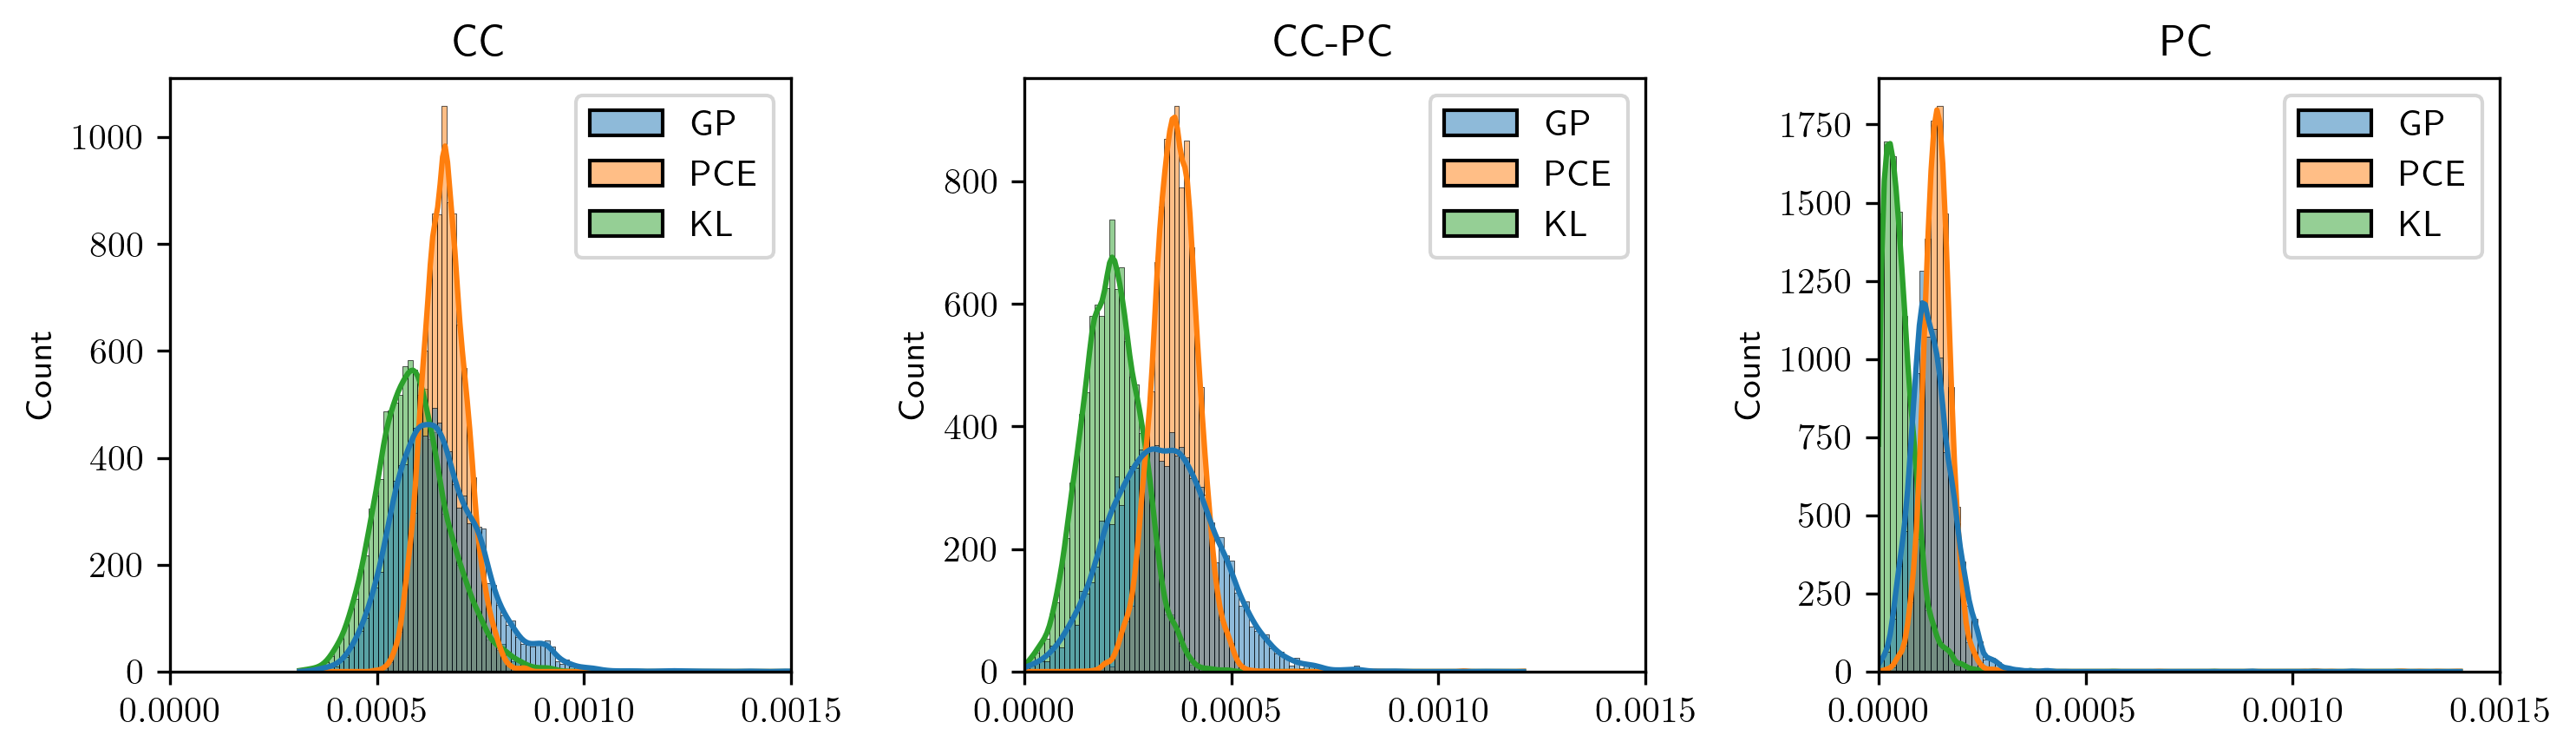

In [25]:
fig, axs = plt.subplots(1, 3, figsize=(10, 3), layout='tight')
sns.histplot(df_cc, kde=True, bins=100, common_norm=True, ax=axs[0])
sns.histplot(df_cc_pc, kde=True, bins=100, common_norm=True, ax=axs[1])
sns.histplot(df_pc, kde=True, bins=100, common_norm=True, ax=axs[2])
axs[0].set_xlim([0, 15e-4])
axs[1].set_xlim([0, 15e-4])
axs[2].set_xlim([0, 15e-4])
axs[0].set_title('CC')
axs[1].set_title('CC-PC')
axs[2].set_title('PC')


In [26]:
with open(BASE_DIRECTORY + '/posterior_distributions/posterior_distributions_gp.pkl', 'wb') as f:
    pickle.dump(ot.ComposedDistribution(posterior_distributions_gp), f)

with open(BASE_DIRECTORY + '/posterior_distributions/posterior_distributions_pce.pkl', 'wb') as f:
    pickle.dump(ot.ComposedDistribution(posterior_distributions_pce), f)

with open(BASE_DIRECTORY + '/posterior_distributions/posterior_distributions_kl.pkl', 'wb') as f:
    pickle.dump(ot.ComposedDistribution(posterior_distributions_kl), f)

In [31]:
sample_gp = np.asarray(ot.ComposedDistribution(posterior_distributions_gp).getSample(1000))
sample_pce = np.asarray(ot.ComposedDistribution(posterior_distributions_pce).getSample(1000))
sample_kl = np.asarray(ot.ComposedDistribution(posterior_distributions_kl).getSample(1000))

In [33]:
np.save(BASE_DIRECTORY + '/posterior_distributions/sample_gp.npy', sample_gp)
np.save(BASE_DIRECTORY + '/posterior_distributions/sample_pce.npy', sample_pce)
np.save(BASE_DIRECTORY + '/posterior_distributions/sample_kl.npy', sample_kl)